In [1]:
print("Last updated: $(read(`date`, String))")

Last updated: Wed Aug 26 14:52:00 PDT 2020


## GP for binary classification (in Turing)

$$
\begin{eqnarray}
y_n \mid p_n &\sim& \text{Bernoulli}(p_n), \text{ for } n=1,\dots, N \\
\text{logit}(\mathbf{p}) &=& \mathbf{L} \cdot \boldsymbol{\eta} + \beta, \text{ where }
\mathbf{L} = \text{cholesky}(\mathbf{K}) \\
\eta_n &\sim& \text{Normal(0, 1)}, \text{ for } n=1,\dots,N \\
\beta &\sim& \text{Normal(0, 1)} \\
\alpha &\sim& \text{LogNormal}(0, 1) \\
\rho &\sim& \text{LogNormal}(0, 1) \\
\end{eqnarray}
$$

Note: 
- $\mathbf{K}$ is an $N\times N$ covariance matrix where
  $K_{n,m} = \alpha^2\exp\left(-{\left\lVert\mathbf{x}_n - \mathbf{x}_m\right\rVert}^2_2\big/\rho^{2}\right)$.
- Each $\mathbf{x}_n$ is an observed 2-dimensional locations, for $n=1,\dots,N$.
- The model above is the same as the more explicit model below. But the model above mixes slowly with ADVI, HMC, and NUTS; while the model above mixes much more quickly.

$$
\begin{eqnarray}
y_n \mid p_n &\sim& \text{Bernoulli}(p_n), \text{ for } n=1,\dots, N \\
\text{logit}(\mathbf{p}) &\sim& \text{MvNormal}(\beta \cdot \mathbf{1}_N, K) \quad\text{(finite GP)} \\
\beta &\sim& \text{Normal(0, 1)} \\
\alpha &\sim& \text{LogNormal}(0, 1) \\
\rho &\sim& \text{LogNormal}(1, 1) \\
\end{eqnarray}
%
$$


In [2]:
# Load environment
import Pkg; Pkg.activate("../../../")

 Activating environment at `~/repo/TuringBnpBenchmarks/Project.toml`


In [3]:
# Import Libraries
using Turing
using Turing: Variational
using Distributions
using AbstractGPs, KernelFunctions
using PyPlot
using StatsFuns
using JSON3
using Flux
using ProgressBars
import Random
import LinearAlgebra

In [4]:
# Define a kernel.
function sekernel(alpha, rho, jitter=0)
  kernel = alpha^2 * transform(SEKernel(), invsqrt2/rho)
  jitter <= 0 || (kernel += jitter * EyeKernel())
  return kernel
end

function compute_f(kernel, X, eta, beta=0, jitter=0)
  K = kernelmatrix(kernel, X, obsdim=1)
  jitter <= 0 || (K += LinearAlgebra.I * jitter)
  return LinearAlgebra.cholesky(K).L * eta .+ beta
end

@model function GPClassify(y, X, jitter=1e-6)
    # Priors.
    alpha ~ LogNormal(0, 1)
    rho ~ LogNormal(0, 1)
    beta ~ Normal(0, 1)  # intercept.
    eta ~ filldist(Normal(0, 1), length(y))

    # Latent GP
    kernel = sekernel(alpha, rho)
    f = compute_f(sekernel(alpha, rho), X, eta, beta, jitter)
    
    # Sampling Distribution.
    y ~ Product(Bernoulli.(logistic.(f)))
end;

In [5]:
# For getting quantiles along array dimensions
quantiles(X, q; dims) = mapslices(x -> quantile(x, q), X, dims=dims)

# To extract parameters from ADVI model.
function make_extractor(m, q; nsamples=300)
    qsamples = rand(q, nsamples)
    _, sym2range = Variational.bijector(m; sym_to_ranges=Val(true))
    return sym -> qsamples[collect(sym2range[sym][1]), :]
end;

function plot_data(X, y; edgecolors=nothing)
    colors = ["blue", "red"]
    plt.scatter(X[:, 1], X[:, 2], color=colors[y .+ 1], edgecolors=edgecolors)
end;

# Function for plotting parameter posterior.
function plot_post(samples, name; bins=nothing, suffix="")
    param = samples[name]
    plt.hist(param, density=true, bins=bins)
    plt.xlabel(name)
    plt.ylabel("density")
    if suffix !== ""
        suffix = "($(suffix))"
    end
    plt.title("Histogram of $(name) $(suffix)");
end;

In [6]:
function makegrid(xmin, xmax, ymin, ymax, ngrid; return_all=false)
  ngrid = floor(Int, sqrt(ngrid))
  grid = [[i, j]
          for i in range(xmin, xmax, length=ngrid),
          j in range(ymin, ymax, length=ngrid)]
  out =  Matrix(hcat(vec(grid)...)')
    
  if return_all
    return out, grid
  else
    return out
  end
end;

In [7]:
function gp_predict(postsamps, X, y, nnew; eps=0, prob=true, jitter=1e-6)
    # Make grid of prediction locations.
    xmin = minimum(X, dims=1)
    xmax = maximum(X, dims=1)
    Xnew, grid = makegrid(xmin[1]-eps, xmax[1]+eps,
                          xmin[2]-eps, xmax[2]+eps,
                          nnew, return_all=true)
    
    # Posterior samples of model parameters.
    alpha = postsamps[:alpha]
    rho = postsamps[:rho]
    beta = postsamps[:beta]
    nsamps = length(alpha)
    eta = postsamps[:eta]
        
    # Predict classification probabilities.
    ps = [let
            kernel = sekernel(alpha[i], rho[i], jitter)
            gp = GP(beta[i], kernel)
            f = compute_f(kernel, X, eta[:, i], beta[i])
            pfx = posterior(gp(X'), f)
            logit_p = rand(pfx(Xnew'))
            prob ? logistic.(logit_p) : logit_p
         end for i in ProgressBar(1:nsamps)]

    return hcat(ps...), Xnew, grid
end;

In [8]:
function plot_kernel_params(post_samples, kernel_params; bins=nothing, figsize=(8,3))
    plt.figure(figsize=figsize)
    nparams = length(kernel_params)
    for i in 1:nparams
        param = kernel_params[i]
        plt.subplot(1, nparams, i)
        plot_post(post_samples, param, bins=bins);
    end
    plt.tight_layout()
end;

In [9]:
function plot_uq(postsamps, X, y, algo;
                 nnew=100, eps=0.2, figsize=(10, 8),
                 kernel_params=nothing, jitter=1e-6,
                 color_res=100, color_res_sd=100, return_stuff=false,
                 data_edgecolors=nothing, vmin_sd=0, vmax_sd=nothing, prob=true)
    nsamps = postsamps[:alpha]
    ps, Xnew, grid = gp_predict(postsamps, X, y, nnew, eps=eps, prob=prob, jitter=jitter)
    
    plt.figure(figsize=figsize)
    gs = [[g[i] for g in grid] for i in 1:2]
    
    # Plot mean function.
    plt.subplot(2, 2, 1)
    if prob
        plt.contourf(gs[1], gs[2], reshape(mean(ps, dims=2), size(gs[1])...),
                     color_res, cmap=plt.get_cmap("bwr"), vmin=0, vmax=1)
    else
        plt.contourf(gs[1], gs[2], reshape(mean(ps, dims=2), size(gs[1])...),
                     color_res, cmap=plt.get_cmap("bwr"))
    end
    plt.colorbar();
    plot_data(X, y, edgecolors=data_edgecolors);
    plt.xticks([]); plt.yticks([]);
    plt.title("Posterior Mean Function ($(algo))")
    
    # Plot function sd.
    plt.subplot(2, 2, 2)
    plt.contourf(gs[1], gs[2], reshape(std(ps, dims=2), size(gs[1])...),
                 color_res_sd, cmap=plt.get_cmap("Oranges"),
                 vmin=vmin_sd, vmax=vmax_sd)
    plt.colorbar();
    plot_data(X, y)
    plt.xticks([]);
    plt.yticks([]);    
    plt.title("Posterior Standard Deviation Function ($algo)")
    
    if kernel_params != nothing
        plot_kernel_params(postsamps, kernel_params, bins=30)
    end
   
    if return_stuff
        return ps, Xnew, grid
    end
end;

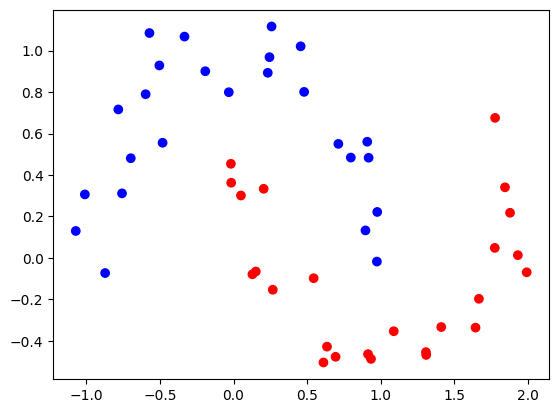

In [10]:
# Read data.

# Path to data.
data_path = joinpath(@__DIR__, "../data/gp-classify-data-N50.json")

# Load data in JSON format.
data = let
    x = open(f -> read(f, String), data_path)
    JSON3.read(x)
end

# Store data.
X = [data["x1"] data["x2"]]
y = Int64.(data["y"])

# Plot data.
plot_data(X, y);

In [11]:
# Create model.
m =  GPClassify(Float64.(y), X);
kernel_params = [:alpha, :rho, :beta];

In [12]:
# Fit via ADVI.
Random.seed!(7)

# NOTE: ADVI(num_elbo_samples, max_iters)

# Compile
@time q = vi(m, ADVI(1, 1))

# RUN
@time q = vi(m, ADVI(1, 1000))
 
# Get posterior samples
extract_gp = make_extractor(m, q, nsamples=500)
advi_samples = Dict{Symbol, Any}(sym => vec(extract_gp(sym)) for sym in kernel_params)
advi_samples[:eta] = extract_gp(:eta);

┌ Info: [ADVI] Should only be seen once: optimizer created for θ
│   objectid(θ) = 2024580348269517261
└ @ Turing.Variational /home/ubuntu/.julia/packages/Turing/NZ9IU/src/variational/VariationalInference.jl:204


 15.272045 seconds (38.36 M allocations: 1.872 GiB, 5.49% gc time)


┌ Info: [ADVI] Should only be seen once: optimizer created for θ
│   objectid(θ) = 10868115068572800385
└ @ Turing.Variational /home/ubuntu/.julia/packages/Turing/NZ9IU/src/variational/VariationalInference.jl:204
[ADVI] Optimizing...: 100%|█████████████████████████████████████████| Time: 0:00:13


 13.175805 seconds (10.30 M allocations: 16.482 GiB, 8.78% gc time)


99.2%┣███████████████████████████████████████▊┫ 496/500 [00:15<00:00, 33.8 it/s]

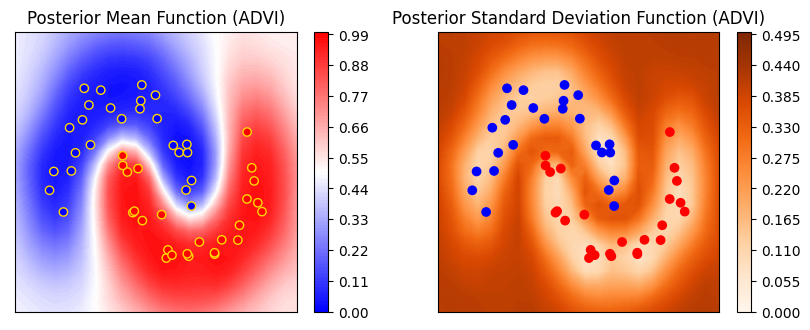

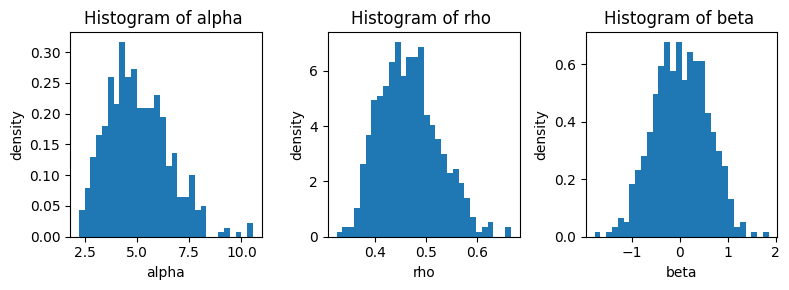

100.0%┣███████████████████████████████████████┫ 500/500 [00:15<00:00, 33.9 it/s]


In [13]:
plot_uq(advi_samples, X, y, "ADVI", eps=0.5,
        nnew=500, data_edgecolors="gold",
        kernel_params=kernel_params,
        color_res=range(0, 1, length=101),
        color_res_sd=range(0, .5, length=101));

## HMC

- stepsize = 0.05
- num leapfrog steps = 20
- burn in: 500
- samples: 500

In [14]:
# Fit via HMC.
Random.seed!(0)
burn = 500
nsamples = 500

# Compile
@time _ = sample(m, HMC(0.01, 1), 1)

# Run
@time hmc_chain = sample(m, HMC(0.05, 20), burn + nsamples);

# Get posterior samples
hmc_samples = Dict{Symbol, Any}([
    sym => vec(group(hmc_chain, sym).value.data)[end-nsamples+1:end]
for sym in kernel_params])
hmc_samples[:eta] = Matrix(group(hmc_chain, :eta).value.data[end-nsamples+1:end, :, 1]');

 20.159321 seconds (46.95 M allocations: 2.402 GiB, 3.89% gc time)


Sampling:   6%|██▍                                      |  ETA: 0:00:54┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/ubuntu/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
Sampling:  41%|████████████████▉                        |  ETA: 0:00:37┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/ubuntu/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:04


 64.382829 seconds (37.11 M allocations: 163.036 GiB, 13.32% gc time)


99.4%┣███████████████████████████████████████▊┫ 497/500 [00:12<00:00, 40.6 it/s]

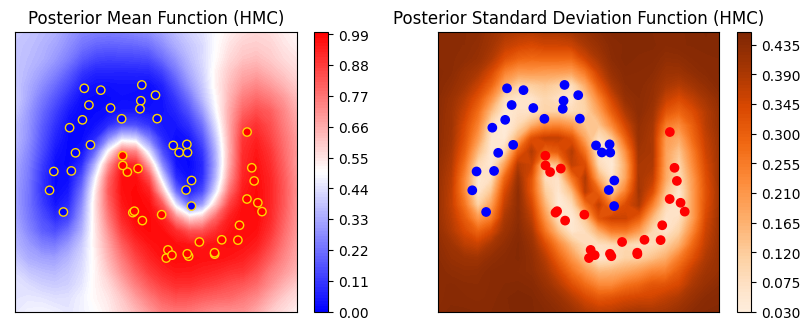

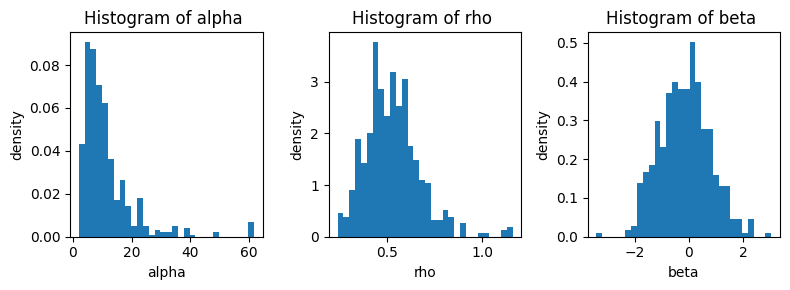

100.0%┣███████████████████████████████████████┫ 500/500 [00:12<00:00, 40.5 it/s]


In [15]:
# Plot HMC
ps, Xnew, grid = plot_uq(hmc_samples, X, y, "HMC", eps=0.5,
                         nnew=500, data_edgecolors="gold",
                         kernel_params=kernel_params,
                         color_res=range(0, 1, length=101),
                         return_stuff=true);

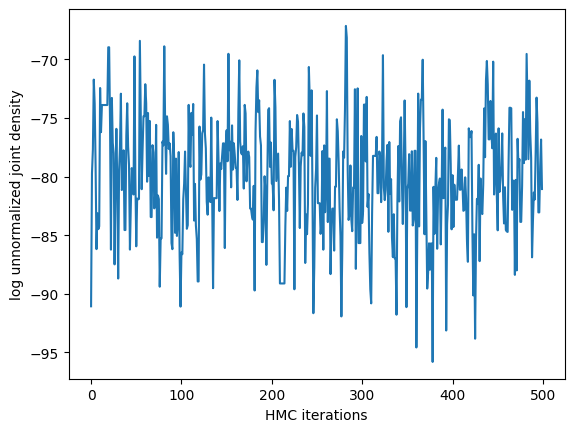

In [16]:
plt.plot(get(hmc_chain, :lp)[1].data[burn+1:end]);
plt.xlabel("HMC iterations");
plt.ylabel("log unnormalized joint density");

In [17]:
# Fit via NUTS.
Random.seed!(0)
burn = 500
nsamples = 500

# Compile
@time _ = sample(m, NUTS(1, 0.8, max_depth=2), 2)

# Run
@time nuts_chain = sample(m, NUTS(burn, 0.8, max_depth=10), burn + nsamples);

# Get posterior samples
nuts_samples = Dict{Symbol, Any}([
    sym => vec(group(nuts_chain, sym).value.data)
for sym in kernel_params])
nuts_samples[:eta] = Matrix(group(nuts_chain, :eta).value.data[:, :, 1]');

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/ubuntu/.julia/packages/Turing/NZ9IU/src/inference/hmc.jl:629
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/ubuntu/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47


 11.684945 seconds (29.64 M allocations: 2.253 GiB, 4.31% gc time)


┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/ubuntu/.julia/packages/Turing/NZ9IU/src/inference/hmc.jl:629
Sampling:   2%|▉                                        |  ETA: 0:03:08┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/ubuntu/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
Sampling:  12%|█████▏                                   |  ETA: 0:02:51┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/ubuntu/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
Sampling:  17%|███████▏                                 |  ETA: 0:02:19┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/ubuntu/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonia

102.772473 seconds (65.90 M allocations: 296.164 GiB, 13.82% gc time)


99.2%┣███████████████████████████████████████▊┫ 496/500 [00:10<00:00, 47.4 it/s]

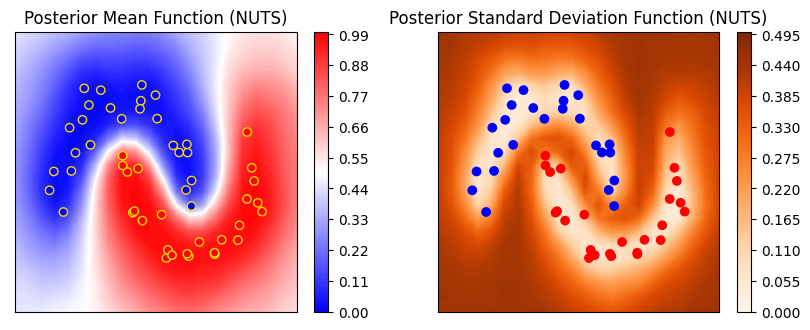

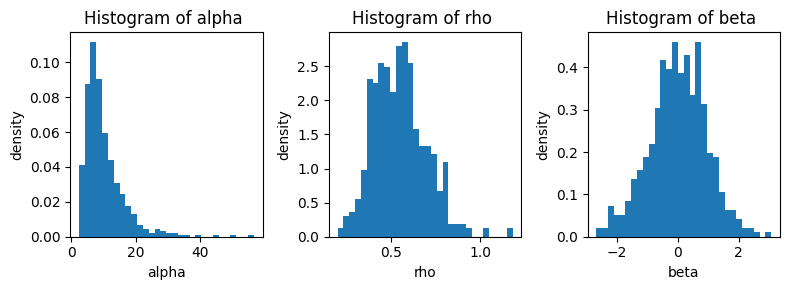

100.0%┣███████████████████████████████████████┫ 500/500 [00:11<00:00, 47.4 it/s]


In [18]:
# Plot NUTS
plot_uq(nuts_samples, X, y, "NUTS", eps=0.5,
        nnew=500, data_edgecolors="gold",
        kernel_params=kernel_params,
        color_res=range(0, 1, length=101),
        color_res_sd=range(0, .5, length=101),
        return_stuff=true);

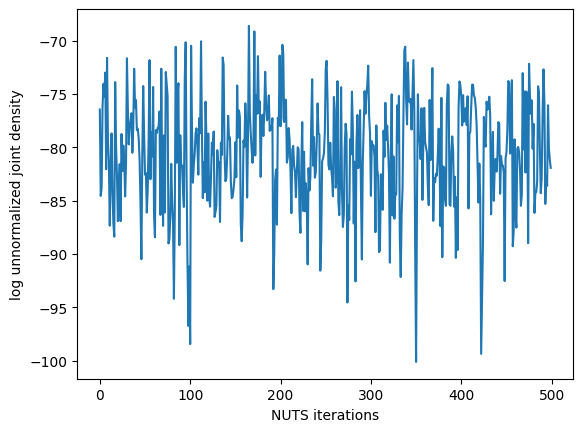

In [19]:
plt.plot(get(nuts_chain, :lp)[1].data);
plt.xlabel("NUTS iterations");
plt.ylabel("log unnormalized joint density");